In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import mutual_info_score, adjusted_rand_score

In [2]:
#cleaning data, removing N/As
df = pd.read_csv("onco_clean.csv")
df_clean = df.dropna()
df_clean.head()

,Unnamed: 0,USUBJID,AGE,RACE,ETHNIC,ECOGBL,WEIGHTBL,HEIGHTBL,ALPBL,ALT,...,PSABL,ALB,WHOATC1,TESTOSBL,edbl_bone,edbl_sftts_node,edbl_viscera_liver,edbl_viscera_lung,BMI,GLEASBL_7
0,1,COU-AA-302_574-8349,79.0,WHITE,NOT HISPANIC OR LATINO,0.0,93.9,172.7,0.592308,0.171429,...,178.40,0.804348,1,0.044814,1,0,0,0,31.483349,<7
1,2,56021927PCR3001-7215371,72.0,WHITE,NOT HISPANIC OR LATINO,1.0,99.0,179.0,0.576923,0.314286,...,6.45,0.978261,1,0.044649,1,0,1,0,30.897912,>=7
2,3,56021927PCR3001-3885944,65.0,ASIAN,NOT HISPANIC OR LATINO,0.0,74.8,166.1,1.288000,0.395349,...,44.79,0.918367,1,0.049815,1,0,0,0,27.112049,>=7
3,4,56021927PCR3001-8496606,67.0,WHITE,NOT HISPANIC OR LATINO,1.0,84.5,175.0,0.840000,0.255814,...,99.78,0.918367,1,0.044649,0,1,0,0,27.591837,>=7
4,5,64091742PCR2001-579693,68.0,WHITE,NOT HISPANIC OR LATINO,0.0,87.4,173.0,1.648000,1.209302,...,2437.00,0.816327,1,0.044816,1,1,1,0,29.202446,<7


In [3]:
#encoding categorical variales
features = ["WEIGHTBL", "HEIGHTBL", "ALPBL", "ALT", "AST", "BILI", "CREAT", "HGBBL", "LDHBL", "PLAT", "PSABL", "ALB", "TESTOSBL", "BMI", "AGE"]
df_clean = pd.get_dummies(df_clean, columns=["RACE", "ETHNIC", "ECOGBL", "WHOATC1", "edbl_bone", "edbl_sftts_node", "edbl_viscera_liver", "edbl_viscera_lung", "GLEASBL_7"], drop_first=True)

race_dummies = [col for col in df_clean.columns if col.startswith("RACE")]
features.extend(race_dummies)
df_clean[race_dummies] = df_clean[race_dummies].astype(int)

ethnic_dummies = [col for col in df_clean.columns if col.startswith("ETHNIC")]
features.extend(ethnic_dummies)
df_clean[ethnic_dummies] = df_clean[ethnic_dummies].astype(int)

ecogbl_dummies = [col for col in df_clean.columns if col.startswith("ECOGBL")]
features.extend(ecogbl_dummies)
df_clean[ecogbl_dummies] = df_clean[ecogbl_dummies].astype(int)

whoatc1_dummies = [col for col in df_clean.columns if col.startswith("WHOATC1")]
features.extend(whoatc1_dummies)
df_clean[whoatc1_dummies] = df_clean[whoatc1_dummies].astype(int)

edbl_bone_dummies = [col for col in df_clean.columns if col.startswith("edbl_bone")]
features.extend(edbl_bone_dummies)
df_clean[edbl_bone_dummies] = df_clean[edbl_bone_dummies].astype(int)

edbl_sftts_node_dummies = [col for col in df_clean.columns if col.startswith("edbl_sftts_node")]
features.extend(edbl_sftts_node_dummies)
df_clean[edbl_sftts_node_dummies] = df_clean[edbl_sftts_node_dummies].astype(int)

edbl_viscera_liver_dummies = [col for col in df_clean.columns if col.startswith("edbl_viscera_liver")]
features.extend(edbl_viscera_liver_dummies)
df_clean[edbl_viscera_liver_dummies] = df_clean[edbl_viscera_liver_dummies].astype(int)

edbl_viscera_lung_dummies = [col for col in df_clean.columns if col.startswith("edbl_viscera_lung")]
features.extend(edbl_viscera_lung_dummies)
df_clean[edbl_viscera_lung_dummies] = df_clean[edbl_viscera_lung_dummies].astype(int)

gleasbl_7_dummies = [col for col in df_clean.columns if col.startswith("GLEASBL_7")]
features.extend(gleasbl_7_dummies)
df_clean[gleasbl_7_dummies] = df_clean[gleasbl_7_dummies].astype(int)

In [4]:
#renaming USUBJID column to 'PatientID' to merge data with survival data later
df_clean = df_clean.rename(columns={'USUBJID': 'PatientID'})
df_clean = df_clean.drop(columns=["Unnamed: 0"])
df_clean.head()

,PatientID,AGE,WEIGHTBL,HEIGHTBL,ALPBL,ALT,AST,BILI,CREAT,HGBBL,...,RACE_WHITE,ETHNIC_NOT HISPANIC OR LATINO,ECOGBL_1.0,ECOGBL_2.0,WHOATC1_1,edbl_bone_1,edbl_sftts_node_1,edbl_viscera_liver_1,edbl_viscera_lung_1,GLEASBL_7_>=7
0,COU-AA-302_574-8349,79.0,93.9,172.7,0.592308,0.171429,0.361111,0.666667,0.733333,0.623529,...,1,1,0,0,1,1,0,0,0,0
1,56021927PCR3001-7215371,72.0,99.0,179.0,0.576923,0.314286,0.583333,0.571429,0.795620,0.770588,...,1,1,1,0,1,1,0,1,0,1
2,56021927PCR3001-3885944,65.0,74.8,166.1,1.288000,0.395349,0.638889,0.619048,0.546218,0.741176,...,0,1,0,0,1,1,0,0,0,1
3,56021927PCR3001-8496606,67.0,84.5,175.0,0.840000,0.255814,0.388889,0.333333,1.042017,0.641176,...,1,1,1,0,1,0,1,0,0,1
4,64091742PCR2001-579693,68.0,87.4,173.0,1.648000,1.209302,2.111111,0.333333,0.890756,0.717647,...,1,1,0,0,1,1,1,1,0,0


In [5]:
#converting to numpy for KMeans
numpy_array_data = df_clean[features].to_numpy()
print(numpy_array_data)

[[ 93.9        172.7          0.59230769 ...   0.           0.
    0.        ]
 [ 99.         179.           0.57692308 ...   1.           0.
    1.        ]
 [ 74.8        166.1          1.288      ...   0.           0.
    1.        ]
 ...
 [ 62.6        163.3          0.61538462 ...   0.           0.
    1.        ]
 [ 88.5        179.           0.63076923 ...   0.           0.
    0.        ]
 [ 61.         165.           0.80769231 ...   0.           0.
    0.        ]]


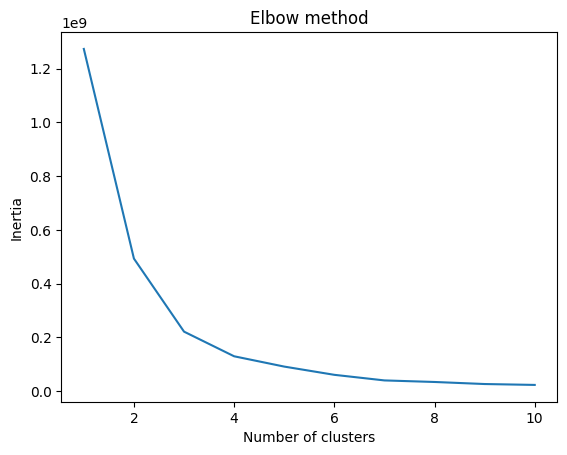

In [6]:
#elbow method for KMeans
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(numpy_array_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias)
plt.title("Elbow method")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [7]:
X = df_clean[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
kmeans = KMeans(n_clusters=3, random_state=0)
labels_km = kmeans.fit_predict(X_scaled)
centroids = kmeans.cluster_centers_
df_clean["KMeans cluster"] = labels_km
df_clean.head()

,PatientID,AGE,WEIGHTBL,HEIGHTBL,ALPBL,ALT,AST,BILI,CREAT,HGBBL,...,ETHNIC_NOT HISPANIC OR LATINO,ECOGBL_1.0,ECOGBL_2.0,WHOATC1_1,edbl_bone_1,edbl_sftts_node_1,edbl_viscera_liver_1,edbl_viscera_lung_1,GLEASBL_7_>=7,KMeans cluster
0,COU-AA-302_574-8349,79.0,93.9,172.7,0.592308,0.171429,0.361111,0.666667,0.733333,0.623529,...,1,0,0,1,1,0,0,0,0,1
1,56021927PCR3001-7215371,72.0,99.0,179.0,0.576923,0.314286,0.583333,0.571429,0.795620,0.770588,...,1,1,0,1,1,0,1,0,1,2
2,56021927PCR3001-3885944,65.0,74.8,166.1,1.288000,0.395349,0.638889,0.619048,0.546218,0.741176,...,1,0,0,1,1,0,0,0,1,1
3,56021927PCR3001-8496606,67.0,84.5,175.0,0.840000,0.255814,0.388889,0.333333,1.042017,0.641176,...,1,1,0,1,0,1,0,0,1,2
4,64091742PCR2001-579693,68.0,87.4,173.0,1.648000,1.209302,2.111111,0.333333,0.890756,0.717647,...,1,0,0,1,1,1,1,0,0,0


/var/folders/2l/lmtfyvln51l043yd4s406mpr0000gp/T/ipykernel_32997/3341325573.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


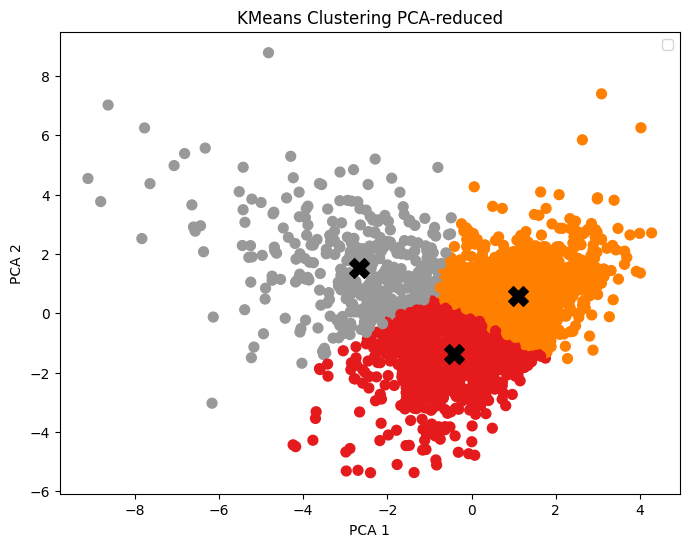

In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=0)
labels_km2 = kmeans.fit_predict(X_pca)
centroids = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_km2, cmap='Set1', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200)
plt.title('KMeans Clustering PCA-reduced')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

In [10]:
#computing to see if KMeans is a good clustering method
silhouette = silhouette_score(X, labels_km)
db_index = davies_bouldin_score(X, labels_km)
ch_index = calinski_harabasz_score(X, labels_km)

print(f"Silhouette Score: {silhouette:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Calinski-Harabasz Index: {ch_index:.2f}")

Silhouette Score: -0.01
Davies-Bouldin Index: 3.73
Calinski-Harabasz Index: 232.52


In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

In [12]:
#agglomerative clusting
X = df_clean[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model_agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agg = model_agg.fit_predict(X_scaled)
df_clean["Agglomerative Cluster"] = labels_agg
df_clean.head()

,PatientID,AGE,WEIGHTBL,HEIGHTBL,ALPBL,ALT,AST,BILI,CREAT,HGBBL,...,ECOGBL_1.0,ECOGBL_2.0,WHOATC1_1,edbl_bone_1,edbl_sftts_node_1,edbl_viscera_liver_1,edbl_viscera_lung_1,GLEASBL_7_>=7,KMeans cluster,Agglomerative Cluster
0,COU-AA-302_574-8349,79.0,93.9,172.7,0.592308,0.171429,0.361111,0.666667,0.733333,0.623529,...,0,0,1,1,0,0,0,0,1,1
1,56021927PCR3001-7215371,72.0,99.0,179.0,0.576923,0.314286,0.583333,0.571429,0.795620,0.770588,...,1,0,1,1,0,1,0,1,2,2
2,56021927PCR3001-3885944,65.0,74.8,166.1,1.288000,0.395349,0.638889,0.619048,0.546218,0.741176,...,0,0,1,1,0,0,0,1,1,1
3,56021927PCR3001-8496606,67.0,84.5,175.0,0.840000,0.255814,0.388889,0.333333,1.042017,0.641176,...,1,0,1,0,1,0,0,1,2,1
4,64091742PCR2001-579693,68.0,87.4,173.0,1.648000,1.209302,2.111111,0.333333,0.890756,0.717647,...,0,0,1,1,1,1,0,0,0,2


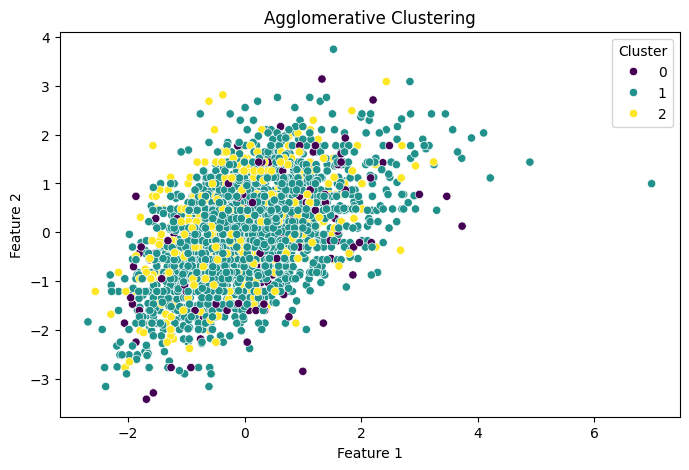

In [13]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue = labels_agg, palette = 'viridis')
plt.title('Agglomerative Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.show()

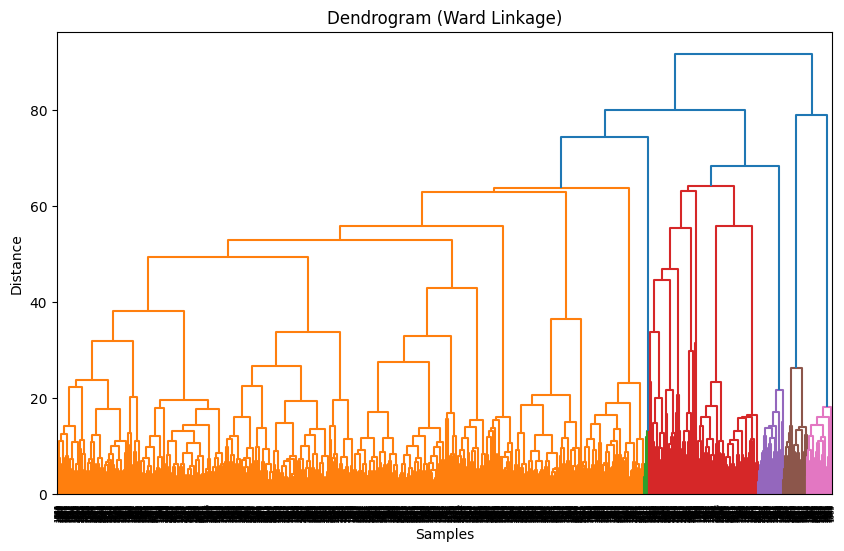

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked, orientation = 'top', distance_sort = 'descending', show_leaf_counts = False)
plt.title('Dendrogram (Ward Linkage)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [15]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn import datasets
from sklearn.metrics import adjusted_rand_score

In [16]:
#density based clustering
X = df_clean[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
db = DBSCAN(eps=0.3, min_samples=10)
clusters = db.fit_predict(X_scaled)
df_clean["DB Cluster"] = clusters
df_clean.head()

,PatientID,AGE,WEIGHTBL,HEIGHTBL,ALPBL,ALT,AST,BILI,CREAT,HGBBL,...,ECOGBL_2.0,WHOATC1_1,edbl_bone_1,edbl_sftts_node_1,edbl_viscera_liver_1,edbl_viscera_lung_1,GLEASBL_7_>=7,KMeans cluster,Agglomerative Cluster,DB Cluster
0,COU-AA-302_574-8349,79.0,93.9,172.7,0.592308,0.171429,0.361111,0.666667,0.733333,0.623529,...,0,1,1,0,0,0,0,1,1,-1
1,56021927PCR3001-7215371,72.0,99.0,179.0,0.576923,0.314286,0.583333,0.571429,0.795620,0.770588,...,0,1,1,0,1,0,1,2,2,-1
2,56021927PCR3001-3885944,65.0,74.8,166.1,1.288000,0.395349,0.638889,0.619048,0.546218,0.741176,...,0,1,1,0,0,0,1,1,1,-1
3,56021927PCR3001-8496606,67.0,84.5,175.0,0.840000,0.255814,0.388889,0.333333,1.042017,0.641176,...,0,1,0,1,0,0,1,2,1,-1
4,64091742PCR2001-579693,68.0,87.4,173.0,1.648000,1.209302,2.111111,0.333333,0.890756,0.717647,...,0,1,1,1,1,0,0,0,2,-1


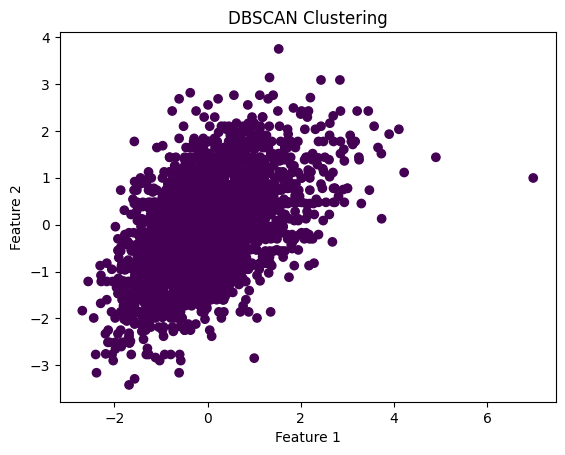

In [17]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title("DBSCAN Clustering")
plt.show()

In [18]:
from sklearn.cluster import MeanShift

In [19]:
#mean shift clustering
X = df_clean[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
mean_shift = MeanShift()
labels_ms = mean_shift.fit_predict(X_scaled)
df_clean["Mean Shift cluster"] = labels_ms
df_clean.head()

,PatientID,AGE,WEIGHTBL,HEIGHTBL,ALPBL,ALT,AST,BILI,CREAT,HGBBL,...,WHOATC1_1,edbl_bone_1,edbl_sftts_node_1,edbl_viscera_liver_1,edbl_viscera_lung_1,GLEASBL_7_>=7,KMeans cluster,Agglomerative Cluster,DB Cluster,Mean Shift cluster
0,COU-AA-302_574-8349,79.0,93.9,172.7,0.592308,0.171429,0.361111,0.666667,0.733333,0.623529,...,1,1,0,0,0,0,1,1,-1,0
1,56021927PCR3001-7215371,72.0,99.0,179.0,0.576923,0.314286,0.583333,0.571429,0.795620,0.770588,...,1,1,0,1,0,1,2,2,-1,0
2,56021927PCR3001-3885944,65.0,74.8,166.1,1.288000,0.395349,0.638889,0.619048,0.546218,0.741176,...,1,1,0,0,0,1,1,1,-1,0
3,56021927PCR3001-8496606,67.0,84.5,175.0,0.840000,0.255814,0.388889,0.333333,1.042017,0.641176,...,1,0,1,0,0,1,2,1,-1,0
4,64091742PCR2001-579693,68.0,87.4,173.0,1.648000,1.209302,2.111111,0.333333,0.890756,0.717647,...,1,1,1,1,0,0,0,2,-1,9


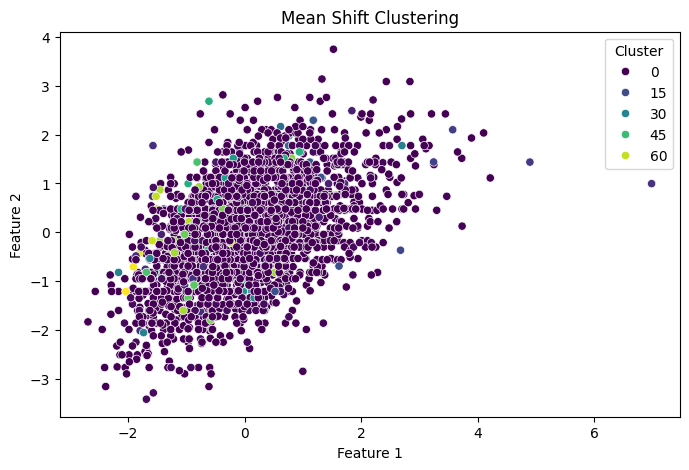

In [20]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue = labels_ms, palette='viridis')
plt.title("Mean Shift Clustering")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.show()

In [21]:
import igraph as ig
import leidenalg
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import kneighbors_graph
import umap.umap_ as umap
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [92]:
#leiden clustering
X = df_clean[features]
X_array = X.values

#dimension reduction
X_tensor = torch.tensor(X_array.astype(np.float32))
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=30):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

autoencoder = Autoencoder(input_dim=X_array.shape[1], latent_dim=10)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(20):
    for batch in loader:
        x_batch = batch[0]
        output = autoencoder(x_batch)
        loss = loss_fn(output, x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

with torch.no_grad():
    latent = autoencoder.encoder(X_tensor).numpy()

#build knn graph
knn_graph = kneighbors_graph(latent, n_neighbors=15, include_self=False)

#convert sparse matrix to graph
sources, targets = knn_graph.nonzero()
edges = list(zip(sources, targets))

#create igraph object
g = ig.Graph(edges=edges, directed=False)
g.vs["name"] = list(range(len(latent)))

#apply leiden clustering
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition, resolution_parameter=0.05)
labels_lc = np.array(partition.membership)

df_clean["Leiden cluster"] = labels_lc
df_clean

,PatientID,AGE,WEIGHTBL,HEIGHTBL,ALPBL,ALT,AST,BILI,CREAT,HGBBL,...,edbl_viscera_lung_1,GLEASBL_7_>=7,KMeans cluster,Agglomerative Cluster,DB Cluster,Mean Shift cluster,Leiden cluster,Hierarchical cluster (Gower Distance),K-Prototypes cluster,LCA prob
0,COU-AA-302_574-8349,79.0,93.9,172.7,0.592308,0.171429,0.361111,0.666667,0.733333,0.623529,...,0,0,1,1,-1,0,1,2,0,0
1,56021927PCR3001-7215371,72.0,99.0,179.0,0.576923,0.314286,0.583333,0.571429,0.795620,0.770588,...,0,1,2,2,-1,0,0,2,0,2
2,56021927PCR3001-3885944,65.0,74.8,166.1,1.288000,0.395349,0.638889,0.619048,0.546218,0.741176,...,0,1,1,1,-1,0,0,2,0,0
3,56021927PCR3001-8496606,67.0,84.5,175.0,0.840000,0.255814,0.388889,0.333333,1.042017,0.641176,...,0,1,2,1,-1,0,0,2,0,2
4,64091742PCR2001-579693,68.0,87.4,173.0,1.648000,1.209302,2.111111,0.333333,0.890756,0.717647,...,0,0,0,2,-1,9,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5792,56021927PCR3001-1258223,89.0,77.0,161.0,0.672000,0.285714,0.416667,0.285714,0.765517,0.652941,...,0,1,1,1,-1,0,0,2,0,0
5795,COU-AA-302_840-5829,60.0,100.7,174.0,0.576000,0.790698,0.805556,0.333333,0.846154,0.782353,...,0,1,2,1,-1,0,0,2,0,1
5796,56021927PCR3001-1289968,70.0,62.6,163.3,0.615385,0.257143,0.472222,0.333333,0.510949,0.741176,...,0,1,1,1,-1,0,0,2,0,0
5797,COU-AA-302_450-9280,75.0,88.5,179.0,0.630769,0.485714,0.583333,0.500000,0.666667,0.688235,...,0,0,1,0,-1,2,0,2,0,1


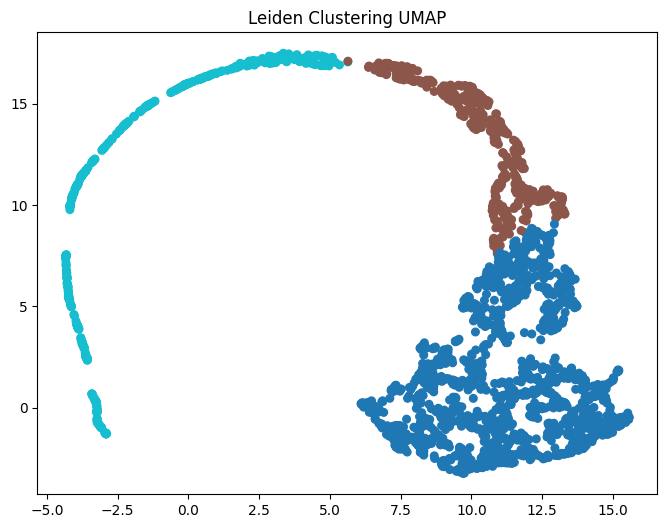

In [93]:
reducer = umap.UMAP()
latent_umap = reducer.fit_transform(latent)

plt.figure(figsize=(8,6))
plt.scatter(latent_umap[:, 0], latent_umap[:, 1], c=labels_lc, cmap='tab10', s=30)
plt.title("Leiden Clustering UMAP")
plt.show()

In [24]:
silhouette = silhouette_score(X_array, labels_lc)
db_index = davies_bouldin_score(X_array, labels_lc)
ch_index = calinski_harabasz_score(X_array, labels_lc)

print(f"Silhouette Score: {silhouette:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Calinski-Harabasz Index: {ch_index:.2f}")

Silhouette Score: 0.62
Davies-Bouldin Index: 0.78
Calinski-Harabasz Index: 1148.50


In [25]:
#Kaplan Meier Curve
from lifelines import KaplanMeierFitter
%matplotlib inline

In [26]:
kmf = KaplanMeierFitter()

In [27]:
#merging clinical data with survival data
survival_df = pd.read_csv("Survival_time_and_censor.csv")
df_merged = pd.merge(survival_df, df_clean[['PatientID', 'Leiden cluster']], on='PatientID', how='inner')
df_merged.head()

,Unnamed: 0,PatientID,OS_time_month,OS_Censor_1_is_censor,Leiden cluster
0,8,COU-AA-301_261-9703,7.556468,0,2
1,9,COU-AA-301_187-2053,11.039014,0,0
2,11,COU-AA-302_974-0100,14.160200,0,0
3,12,56021927PCR3001-5742910,52.008214,1,0
4,13,COU-AA-302_783-8263,34.891200,0,1


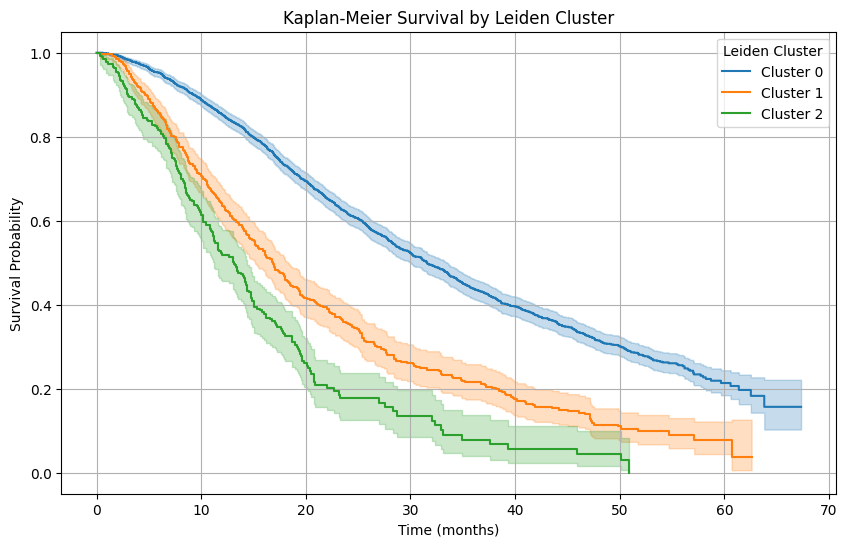

In [95]:
plt.figure(figsize=(10, 6))
df_merged['OS_Censor_1_is_censor'] = (df_merged['OS_Censor_1_is_censor'] + 1) %2
for cluster_id in sorted(df_merged['Leiden cluster'].unique()):
    group = df_merged[df_merged["Leiden cluster"] == cluster_id]
    kmf.fit(durations=group['OS_time_month'], event_observed=group['OS_Censor_1_is_censor'], label=f'Cluster {cluster_id}')
    kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival by Leiden Cluster')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.legend(title="Leiden Cluster")
plt.grid(True)
plt.show()

In [29]:
import gower

In [30]:
gower_dist = gower.gower_matrix(df_clean)

/var/folders/2l/lmtfyvln51l043yd4s406mpr0000gp/T/ipykernel_32997/3534526469.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(gower_dist, method='average')


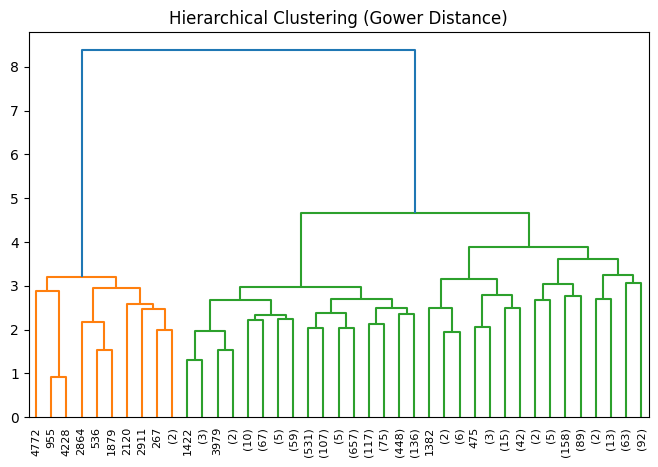

In [31]:
#gower distance
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
linkage_matrix = linkage(gower_dist, method='average')
plt.figure(figsize=(8, 5))
dendrogram(linkage_matrix, labels = df_clean.index.tolist(), truncate_mode='level', p=5)
plt.title("Hierarchical Clustering (Gower Distance)")
plt.show()

In [32]:
labels = fcluster(linkage_matrix, t=2, criterion='maxclust')
df_clean["Hierarchical cluster (Gower Distance)"] = labels
df_clean.head()

,PatientID,AGE,WEIGHTBL,HEIGHTBL,ALPBL,ALT,AST,BILI,CREAT,HGBBL,...,edbl_sftts_node_1,edbl_viscera_liver_1,edbl_viscera_lung_1,GLEASBL_7_>=7,KMeans cluster,Agglomerative Cluster,DB Cluster,Mean Shift cluster,Leiden cluster,Hierarchical cluster (Gower Distance)
0,COU-AA-302_574-8349,79.0,93.9,172.7,0.592308,0.171429,0.361111,0.666667,0.733333,0.623529,...,0,0,0,0,1,1,-1,0,1,2
1,56021927PCR3001-7215371,72.0,99.0,179.0,0.576923,0.314286,0.583333,0.571429,0.795620,0.770588,...,0,1,0,1,2,2,-1,0,0,2
2,56021927PCR3001-3885944,65.0,74.8,166.1,1.288000,0.395349,0.638889,0.619048,0.546218,0.741176,...,0,0,0,1,1,1,-1,0,0,2
3,56021927PCR3001-8496606,67.0,84.5,175.0,0.840000,0.255814,0.388889,0.333333,1.042017,0.641176,...,1,0,0,1,2,1,-1,0,0,2
4,64091742PCR2001-579693,68.0,87.4,173.0,1.648000,1.209302,2.111111,0.333333,0.890756,0.717647,...,1,1,0,0,0,2,-1,9,2,2


In [33]:
from kmodes.kprototypes import KPrototypes

In [34]:
print(X.columns)

Index(['WEIGHTBL', 'HEIGHTBL', 'ALPBL', 'ALT', 'AST', 'BILI', 'CREAT', 'HGBBL',
       'LDHBL', 'PLAT', 'PSABL', 'ALB', 'TESTOSBL', 'BMI', 'AGE', 'RACE_BLACK',
       'RACE_OTHER', 'RACE_WHITE', 'ETHNIC_NOT HISPANIC OR LATINO',
       'ECOGBL_1.0', 'ECOGBL_2.0', 'WHOATC1_1', 'edbl_bone_1',
       'edbl_sftts_node_1', 'edbl_viscera_liver_1', 'edbl_viscera_lung_1',
       'GLEASBL_7_>=7'],
      dtype='object')


In [35]:
#K-Prototypes clustering
#X_array
cat_cols = [15, 26]
kproto = KPrototypes(n_clusters=2, init='Cao', verbose=2)
clusters = kproto.fit_predict(X_array, categorical=cat_cols)
df_clean["K-Prototypes cluster"] = clusters
df_clean.head()

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 38, ncost: 504482462.6907356
Run: 1, iteration: 2/100, moves: 9, ncost: 500818219.1218347
Run: 1, iteration: 3/100, moves: 11, ncost: 496445110.60508156
Run: 1, iteration: 4/100, moves: 9, ncost: 493147311.0340938
Run: 1, iteration: 5/100, moves: 0, ncost: 493147311.0340938
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1005, ncost: 777601173.4851085
Run: 2, iteration: 2/100, moves: 265, ncost: 587739813.1860744
Run: 2, iteration: 3/100, moves: 82, ncost: 508180450.76385486
Run: 2, iteration: 4/100, moves: 14, ncost: 501484444.4116617
Run: 2, iteration: 5/100, moves: 13, ncost: 496445110.60508096
Run: 2, iteration: 6/100, moves: 9, ncost: 493147311.0340935
Run: 2, iteration: 7/10

,PatientID,AGE,WEIGHTBL,HEIGHTBL,ALPBL,ALT,AST,BILI,CREAT,HGBBL,...,edbl_viscera_liver_1,edbl_viscera_lung_1,GLEASBL_7_>=7,KMeans cluster,Agglomerative Cluster,DB Cluster,Mean Shift cluster,Leiden cluster,Hierarchical cluster (Gower Distance),K-Prototypes cluster
0,COU-AA-302_574-8349,79.0,93.9,172.7,0.592308,0.171429,0.361111,0.666667,0.733333,0.623529,...,0,0,0,1,1,-1,0,1,2,0
1,56021927PCR3001-7215371,72.0,99.0,179.0,0.576923,0.314286,0.583333,0.571429,0.795620,0.770588,...,1,0,1,2,2,-1,0,0,2,0
2,56021927PCR3001-3885944,65.0,74.8,166.1,1.288000,0.395349,0.638889,0.619048,0.546218,0.741176,...,0,0,1,1,1,-1,0,0,2,0
3,56021927PCR3001-8496606,67.0,84.5,175.0,0.840000,0.255814,0.388889,0.333333,1.042017,0.641176,...,0,0,1,2,1,-1,0,0,2,0
4,64091742PCR2001-579693,68.0,87.4,173.0,1.648000,1.209302,2.111111,0.333333,0.890756,0.717647,...,1,0,0,0,2,-1,9,2,2,1


In [36]:
from sklearn.preprocessing import LabelEncoder

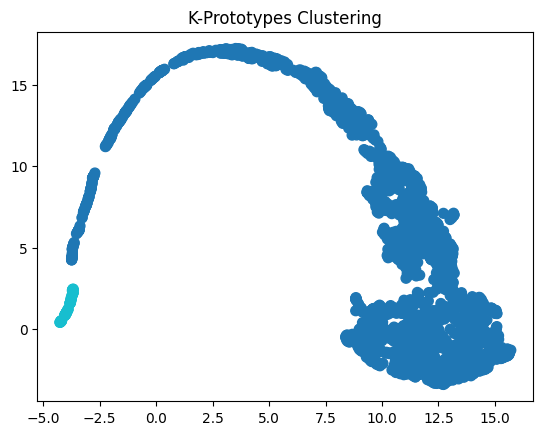

In [38]:
df_encoded = df_clean.copy()
df_encoded = df_encoded.drop(columns=["PatientID"])
for col in ['RACE_BLACK', 'GLEASBL_7_>=7']:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
reducer = umap.UMAP()
embedding = reducer.fit_transform(df_encoded.drop('K-Prototypes cluster', axis=1))
plt.scatter(embedding[:, 0], embedding[:, 1], c=df_clean["K-Prototypes cluster"], cmap='tab10', s=50)
plt.title("K-Prototypes Clustering")
plt.show()

In [39]:
from sklearn.mixture import GaussianMixture

In [40]:
encoded_cat = [col for col in df_clean.columns if any(prefix in col for prefix in ["RACE", "ETHNIC", "ECOGBL", "WHOATC1", "edbl_bone", "edbl_sftts_node", "edbl_viscera_liver", "edbl_viscera_lung", "GLEASBL_7"])]
df_cat = df_clean[encoded_cat]

In [41]:
#Latent Class Analysis 
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(df_cat)
probs = gmm.predict_proba(df_cat)
labels_gmm = gmm.predict(df_cat)
df_clean["LCA prob"] = labels_gmm
df_clean.head()

,PatientID,AGE,WEIGHTBL,HEIGHTBL,ALPBL,ALT,AST,BILI,CREAT,HGBBL,...,edbl_viscera_lung_1,GLEASBL_7_>=7,KMeans cluster,Agglomerative Cluster,DB Cluster,Mean Shift cluster,Leiden cluster,Hierarchical cluster (Gower Distance),K-Prototypes cluster,LCA prob
0,COU-AA-302_574-8349,79.0,93.9,172.7,0.592308,0.171429,0.361111,0.666667,0.733333,0.623529,...,0,0,1,1,-1,0,1,2,0,0
1,56021927PCR3001-7215371,72.0,99.0,179.0,0.576923,0.314286,0.583333,0.571429,0.795620,0.770588,...,0,1,2,2,-1,0,0,2,0,2
2,56021927PCR3001-3885944,65.0,74.8,166.1,1.288000,0.395349,0.638889,0.619048,0.546218,0.741176,...,0,1,1,1,-1,0,0,2,0,0
3,56021927PCR3001-8496606,67.0,84.5,175.0,0.840000,0.255814,0.388889,0.333333,1.042017,0.641176,...,0,1,2,1,-1,0,0,2,0,2
4,64091742PCR2001-579693,68.0,87.4,173.0,1.648000,1.209302,2.111111,0.333333,0.890756,0.717647,...,0,0,0,2,-1,9,2,2,1,1


/Users/vanessa/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


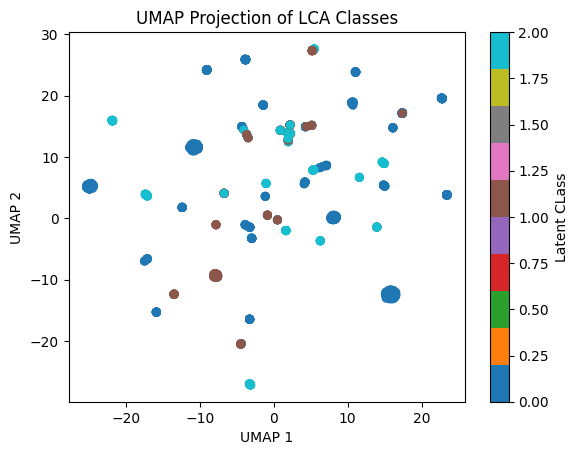

In [43]:
embedding_dummies = umap.UMAP(random_state=42).fit_transform(StandardScaler().fit_transform(df_cat))
plt.scatter(embedding_dummies[:, 0], embedding_dummies[:, 1], c=labels_gmm, cmap='tab10', s=30)
plt.title("UMAP Projection of LCA Classes")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Latent CLass")
plt.show()

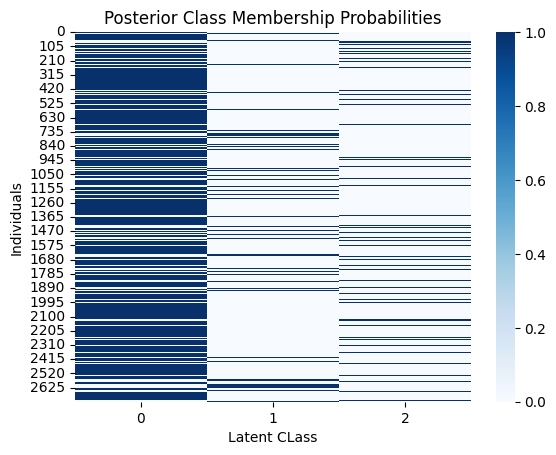

In [44]:
import seaborn as sns
sns.heatmap(probs, cmap="Blues", cbar=True)
plt.title("Posterior Class Membership Probabilities")
plt.xlabel("Latent CLass")
plt.ylabel("Individuals")
plt.show()

In [45]:
from lifelines import CoxPHFitter

In [96]:
df_clean_merged = df_merged.drop(columns = ['PatientID', 'Unnamed: 0'])
df_encoded_leiden = pd.get_dummies(df_clean_merged, columns = ["Leiden cluster"], drop_first=True)

In [97]:
df_encoded_leiden

,OS_time_month,OS_Censor_1_is_censor,Leiden cluster_1,Leiden cluster_2
0,7.556468,1,False,True
1,11.039014,1,False,False
2,14.160200,1,False,False
3,52.008214,0,False,False
4,34.891200,1,True,False
...,...,...,...,...
2724,3.975359,0,False,True
2725,19.613963,0,False,False
2726,31.178600,1,False,False
2727,21.059548,0,True,False


In [98]:
#cox hazards model
cph = CoxPHFitter()
cph.fit(df_encoded_leiden[["OS_time_month", "OS_Censor_1_is_censor", "Leiden cluster_1", "Leiden cluster_2"]], duration_col = 'OS_time_month', event_col = 'OS_Censor_1_is_censor')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2729 total observations, 896 right-censored observations>
             duration col = 'OS_time_month'
                event col = 'OS_Censor_1_is_censor'
      baseline estimation = breslow
   number of observations = 2729
number of events observed = 1833
   partial log-likelihood = -13069.26
         time fit was run = 2025-08-08 04:33:01 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Leiden cluster_1  0.74      2.09      0.06            0.62            0.85                1.86                2.35
Leiden cluster_2  1.23      3.41      0.08            1.07            1.38                2.93                3.97

                  cmp to     z      p  -log2(p)
covariate                                      
Leiden cluster_1    0.00 12.40 <0.005    114.93
Leiden cluster_2    0.00 15.78 <0.005    183.93
---
Concordance = 0.60
Partial AIC = 26142.53
log-likelihood ratio test = 288.92 on 2 df
-log2(p) of ll-ratio test = 208.41

In [99]:
#calculating c statistic
c_index = cph.concordance_index_
print("C-index", c_index)

C-index 0.5990701897460613


In [66]:
from sksurv.datasets import get_x_y
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import train_test_split
from sksurv.metrics import integrated_brier_score

In [100]:
#calculating integrated brier scores
#df_encoded_leiden
cox_features = [col for col in df_encoded_leiden if col.startswith("Leiden cluster_")]
X_cox = df_encoded_leiden[cox_features]
y = Surv.from_dataframe(event="OS_Censor_1_is_censor", time="OS_time_month", data = df_encoded_leiden)
X_train, X_test, y_train, y_test = train_test_split(X_cox, y, test_size=0.3, random_state=42)
model = CoxPHSurvivalAnalysis()
model.fit(X_train, y_train)
times_train = np.array([t for e, t in y_train])
times_test = np.array([t for e, t in y_test])
overall_max = min(times_train.max(), times_test.max()) * 0.99
overall_min = max(times_train.min(), times_test.min())
time_grid = np.linspace(overall_min, overall_max, 100)
pred_surv_train = model.predict_survival_function(X_train)
pred_surv_test = model.predict_survival_function(X_test)
pred_surv_train_matrix = np.asarray([fn(time_grid) for fn in pred_surv_train])
pred_surv_test_matrix = np.asarray([fn(time_grid) for fn in pred_surv_test])
ibs_train = integrated_brier_score(y_train, y_train, pred_surv_train_matrix, time_grid)
ibs_test = integrated_brier_score(y_train, y_test, pred_surv_test_matrix, time_grid)
print(f"Train IBS: {ibs_train:.4f}")
print(f"Test IBS: {ibs_test:.4f}")
risk_scores_train = model.predict(X_train)
risk_scores_test = model.predict(X_test)


Train IBS: 0.1700
Test IBS: 0.1721


/Users/vanessa/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/vanessa/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/vanessa/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/vanessa/Library/Python/3.9/

In [102]:
#calculating time related AUC scores
from sksurv.metrics import cumulative_dynamic_auc
cox_features = [col for col in df_encoded_leiden if col.startswith("Leiden cluster_")]
X_cox = df_encoded_leiden[cox_features]
y = Surv.from_dataframe(event="OS_Censor_1_is_censor", time="OS_time_month", data = df_encoded_leiden)
X_train, X_test, y_train, y_test = train_test_split(X_cox, y, test_size=0.3, random_state=42)
model = CoxPHSurvivalAnalysis()
model.fit(X_train, y_train)
risk_scores_train = model.predict(X_train)
risk_scores_test = model.predict(X_test)
times_test = np.array([t for e, t in y_test])
events_test = np.array([e for e, t in y_test])
event_times_test = times_test[events_test == True]
start_time = np.percentile(event_times_test, 2)
end_time = np.percentile(event_times_test, 98)
time_grid2 = np.linspace(start_time, end_time, 50)
#np.linspace(start_time, end_time, 100)
times_auc_train, auc_train = cumulative_dynamic_auc(y_train, y_train, risk_scores_train, time_grid2)
times_auc_test, auc_test = cumulative_dynamic_auc(y_train, y_test, risk_scores_test, time_grid2)
print(f"Train AUC (mean): {np.mean(auc_train):.4f}")
print(f"Test AUC (mean):", np.mean(auc_test))
print("auc_test shape:", auc_test.shape)
print("Train AUC shape:", auc_train.shape)
print("Test AUC shape:", auc_test.shape)
print("Returned AUC shape:", auc_test.shape if isinstance(auc_test, np.ndarray) else "scalar") 
print("Returned AUC:", auc_test) 

Train AUC (mean): 0.6462
Test AUC (mean): 0.6449563027536989
auc_test shape: ()
Train AUC shape: ()
Test AUC shape: ()
Returned AUC shape: scalar
Returned AUC: 0.6449563027536989


/Users/vanessa/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/vanessa/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/vanessa/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


<Axes: xlabel='log(HR) (95% CI)'>

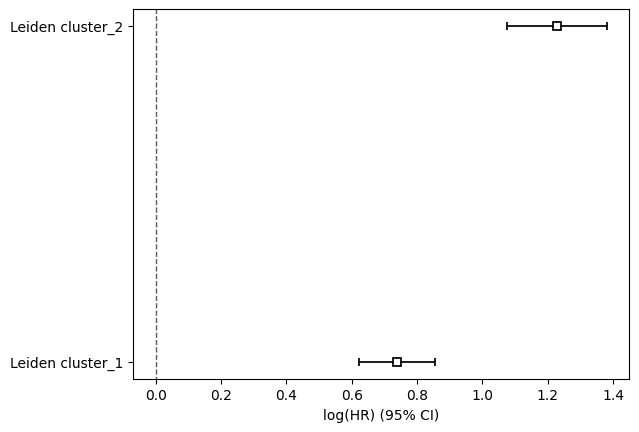

In [103]:
cph.plot()